In [54]:

import cv2
import random
from keras.models import load_model
from skimage.measure import label
import numpy as np
#import pytesseract
from PIL import Image
#from pytesseract import image_to_string
import matplotlib.pyplot as plt


In [55]:
# Path of model 

model_path='/home/ahmed/Downloads/aihack/code/weights/first_try_model.h5'
digit_recognition=load_model(model_path)
width=28
#import a random image from the images folder
image_index=str(random.randint(0,900))
img_path = "/home/ahmed/Downloads/aihack/license_plates_recognition_train/"+image_index+".jpg"



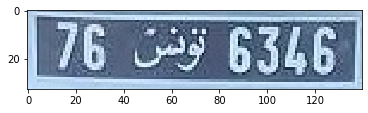

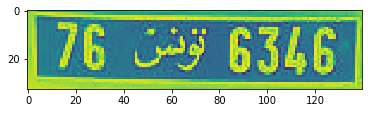

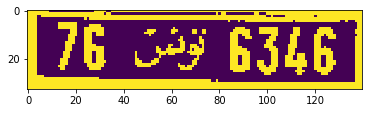

In [56]:
#preprocessing the image
img = cv2.imread(img_path,3)    
plt.imshow(img)
plt.show(block=False)
grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
plt.imshow(grey)
plt.show(block=False)

#blurred=cv2.GaussianBlur(grey, (3, 3), 0)
#plt.imshow(blurred)
#plt.show(block=False)

_,thresh1 = cv2.threshold(grey, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(thresh1)
plt.show(block=False)


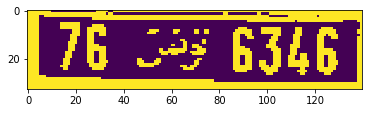

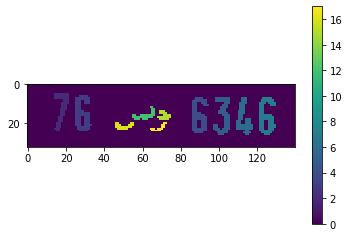

In [57]:

#    thresh1 = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 199, 5) 
#    contours, hierarchy =cv2.findContours(thresh1.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
#    cv2.drawContours(thresh1, contours, -1, (0,255,0), 3)

#applying both erode to make thresh1lines thinner and dilate wich does the opposite
#this was done to to attempt to seperate the numbers from the border lines wich will be removed



thresh1 = cv2.erode(thresh1,np.ones((1,2),np.uint8),iterations = 1)
plt.imshow(thresh1)


thresh1 = cv2.dilate(thresh1,np.ones((1,2),np.uint8),iterations = 1)
plt.imshow(thresh1)
# using label from skimage.measure to label connected (neighboring) regions of an integer array that hold the same value 
#and label them as shapes
kk= label(thresh1)
plt.imshow(thresh1)
plt.show(block=False)
for i in range(np.max(kk)+1):
    contour_check= np.where(kk==i)
    if len(contour_check)!=0:            
        if (np.min(contour_check[0])==0 or np.min(contour_check[1])==0 or np.max(contour_check[0])==kk.shape[0]-1 or np.max(contour_check[1])==kk.shape[1]-1):
            kk[kk==i]=0

#removing any shape adjacent to the borders of the image 
#this is done to eliminate the white frame of the plate            
    if np.count_nonzero(kk==i)<10:
        kk[kk==i]=0
#removing any shape that covers less than 10 pixels         
    if np.max(contour_check[-1])-np.min(contour_check[-1]) > 20 :
        kk[kk==i]=0
#removing any shape that with a length > 20      
plt.imshow(kk) 
plt.colorbar()  

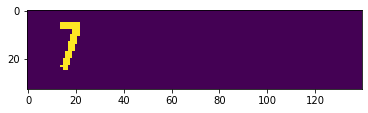

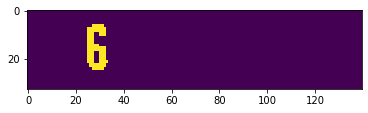

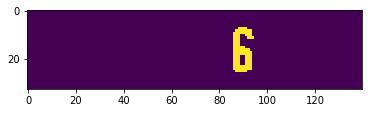

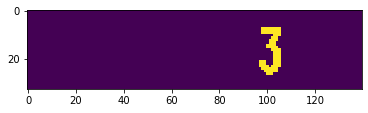

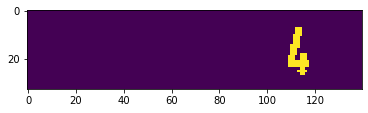

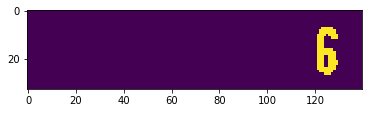

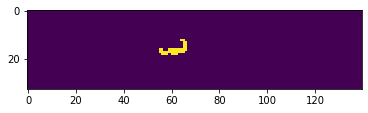

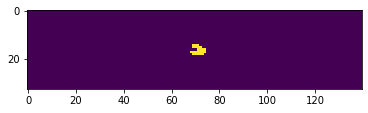

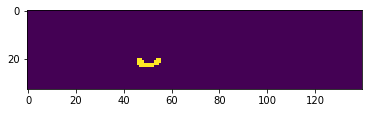

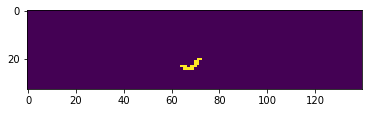

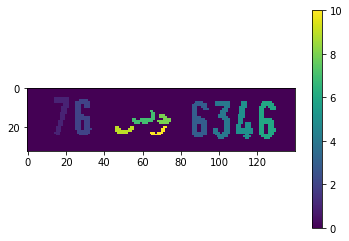

In [58]:

kk= label(kk)

#kk[kk>12]=0
#plt.imshow(thresh1)
image_extracted=np.empty(np.max(kk),dtype=object)      
list_shape=[]

for i in range(1,np.max(kk) +1) :
    coordinates=np.where(kk==i)
    draft=np.copy(kk)
    draft[kk!=i]=0
    min_x,max_x,min_y,max_y=np.min(coordinates[0]),np.max(coordinates[0]),np.min(coordinates[-1]),np.max(coordinates[-1])
    list_shape.append(max_x-min_x)
    
    plt.imshow(draft.astype(np.uint8))
    plt.show(block=False)
    
    if list_shape[i-1]<5:
        list_shape[i-1]=0
#The previous commands deletes shapes with a lenght less than 5 pixels
# This is done to eliminate any small shapes (that aren't digits) that remained after thresholding
        
    squaring=int((max_x-min_x+4-(max_y-min_y))/2)
    image_extracted[i-1,]=draft[min_x-2:max_x+2,min_y-squaring:max_y+squaring]
aa=np.array(list_shape)
aa[aa==0]=np.max(aa)+1
mean=np.mean(aa)
image_extracted_post=np.empty(len(np.where(list_shape>mean-2)[0]),dtype=object)

image_extracted_resized=np.zeros((len(np.where(list_shape>mean-2)[0]),width,width))  
#extracting each digit from the original image and resizing it in order to pass it to the model
plt.imshow(kk.astype(np.uint8)) 
plt.colorbar() 
   

aa[aa>np.max(list_shape)]=0
list_shape=list(aa)


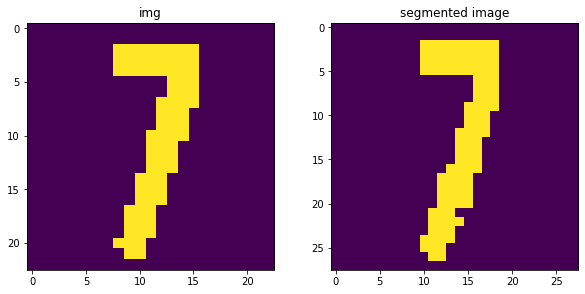

7 



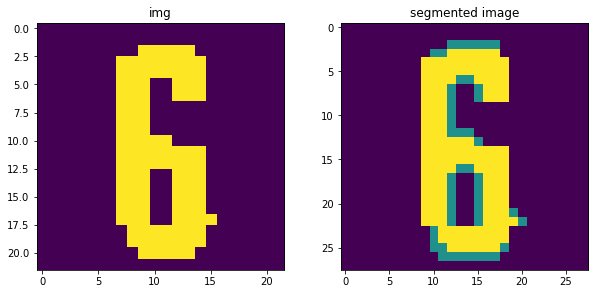

6 



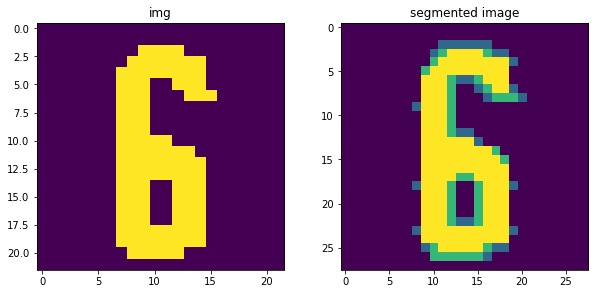

6 



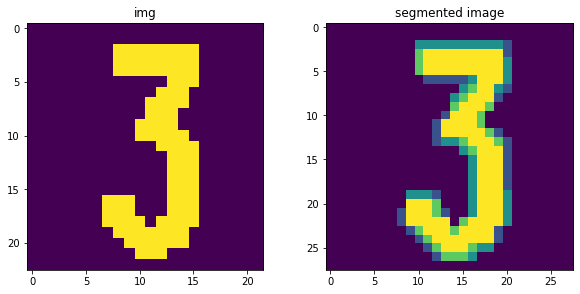

3 



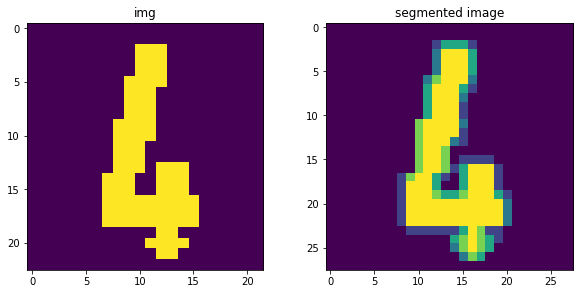

6 



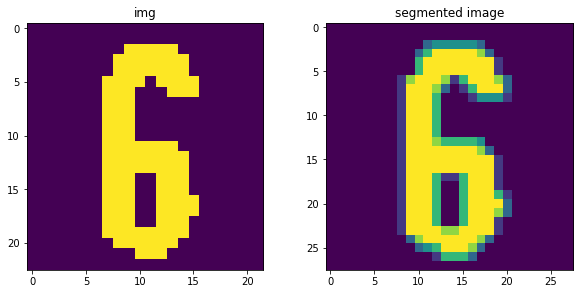

6 



In [59]:
#pasing the extracted digit pictures to the trained model
k=0
pred=[]
pl=[]
for i in range(len(image_extracted)):
    if list_shape[i]>(mean-2):
        image_extracted_post[k]=image_extracted[i] 
        image_extracted_resized[k,:,:]=cv2.resize(image_extracted_post[k].astype(np.uint8),(width,width),cv2.INTER_NEAREST)  
        image_extracted_resized[k]=(image_extracted_resized[k]/np.max(image_extracted_resized[k]))
#        image_extracted_resized[k] = cv2.erode(image_extracted_resized[k], kernel = np.ones((3, 3), np.uint8), iterations=1)
        pred.append(np.argmax(digit_recognition.predict(image_extracted_resized[k].reshape((1,1,width,width)))))
        fig=plt.figure(figsize=(10,10))
        ax1=plt.subplot(221)
        ax1.imshow(image_extracted_post[k])
        ax1.set_title('img')
        ax2=plt.subplot(222)
        ax2.imshow(image_extracted_resized[k])
        ax2.set_title('segmented image')
        plt.show(block=False)
        print(pred[k],'\n')
        pl.append(pred[k])
        k+=1            



[7, 6, 6, 3, 6, 6]


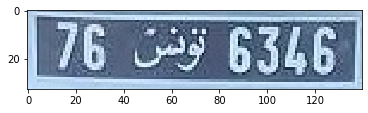

In [60]:
print(pl)
plt.imshow(img)        
        